# Experiments: Model based on U-Net - Trained on Azure

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os

if 'notebooks' in os.getcwd():
    os.chdir("..")

print(os.getcwd())

/Users/jh/ai/courses/stanford/3-ML_RL/final_project/xcs229ii_final_project/code


### Helper methods

## Load Model Weights From Azure Instance

### Experiment 10 - VGG, ImageNet Weights, 128x128

Experiments based on [experiment list](https://docs.google.com/spreadsheets/d/1bsp8puoiK3ay0rUYdjFXcbxXf6iSJZenIWtoiWczlBA/edit#gid=1999600204https://docs.google.com/spreadsheets/d/1bsp8puoiK3ay0rUYdjFXcbxXf6iSJZenIWtoiWczlBA/edit#gid=1999600204).

Segmentation Models: using `tf.keras` framework.


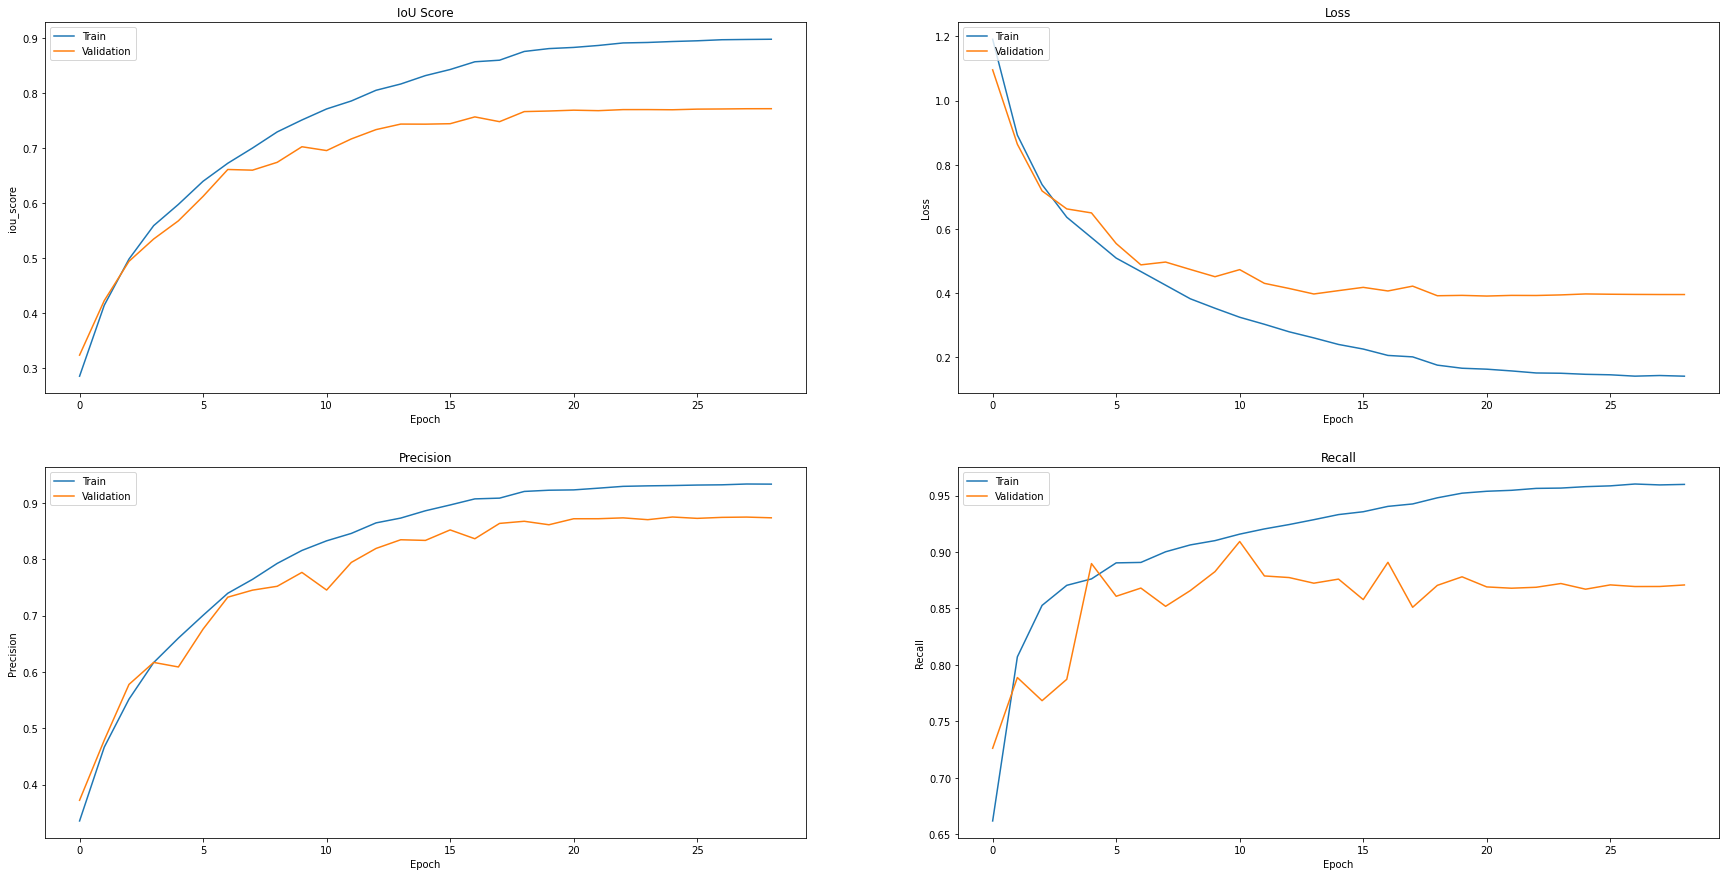

In [3]:
from utils.helper import Visualisation
import pickle
import os
from constants import EXPORT_DIR

AZURE_PATH = os.path.join(EXPORT_DIR, "azure", "2021_05_17_2340", "unet")

azure_hitory_path = os.path.join(AZURE_PATH, "unet_10_train_history.pkl")
azure_history = pickle.load(open(azure_hitory_path, "rb"))
Visualisation().plot_curves(azure_history)

#### Test Images (Unseen)

In [4]:
from baseline.trainer import Trainer
import segmentation_models as sm

azure_model = sm.Unet(encoder_weights='imagenet', activation='sigmoid')
azure_model.load_weights(os.path.join(AZURE_PATH, "unet_10_weights_only.h5"))

In [5]:
from constants import TEST_DIR
from utils.helper import NotebookHelper

test_images, test_masks = NotebookHelper().load_images(TEST_DIR, load_masks=True, resize_to=(128, 128), size=5)

Image shape: (1, 128, 128, 3)
Predicted mask shape: (1, 128, 128, 1)
Mask shape: (128, 128, 1)


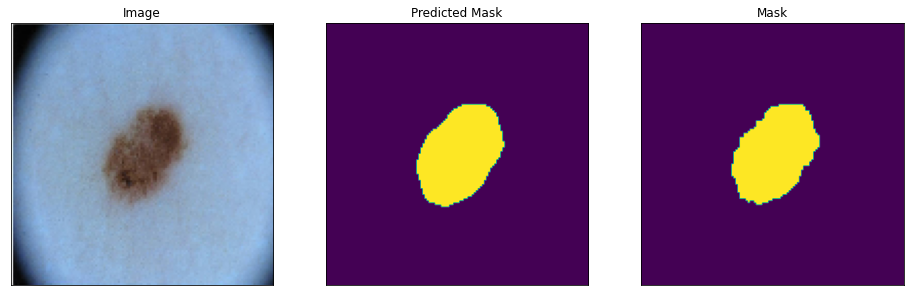

Image shape: (1, 128, 128, 3)
Predicted mask shape: (1, 128, 128, 1)
Mask shape: (128, 128, 1)


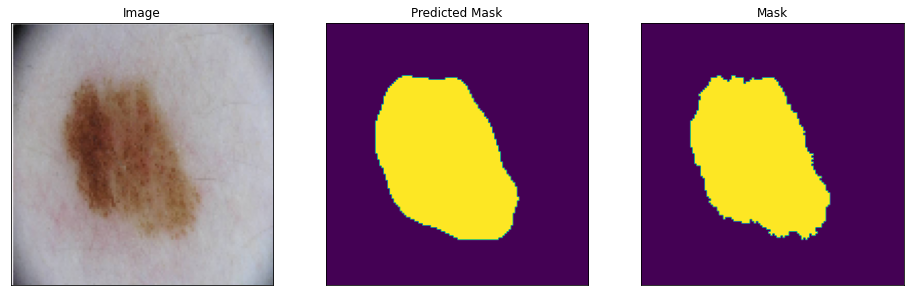

Image shape: (1, 128, 128, 3)
Predicted mask shape: (1, 128, 128, 1)
Mask shape: (128, 128, 1)


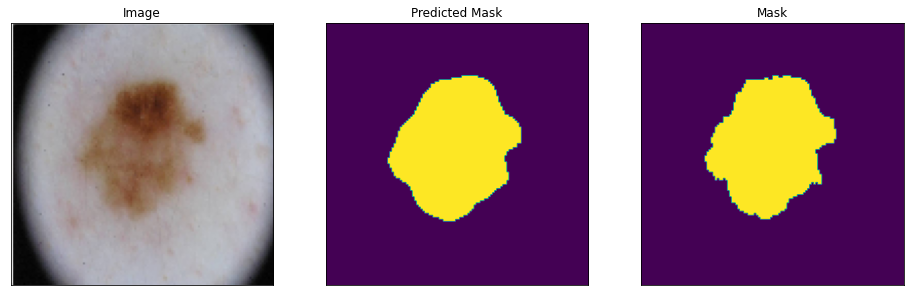

Image shape: (1, 128, 128, 3)
Predicted mask shape: (1, 128, 128, 1)
Mask shape: (128, 128, 1)


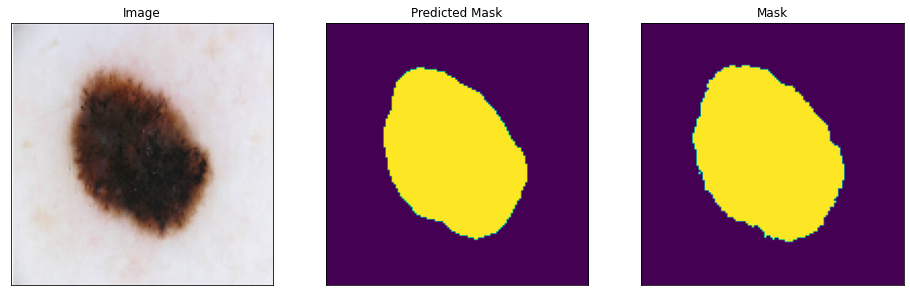

Image shape: (1, 128, 128, 3)
Predicted mask shape: (1, 128, 128, 1)
Mask shape: (128, 128, 1)


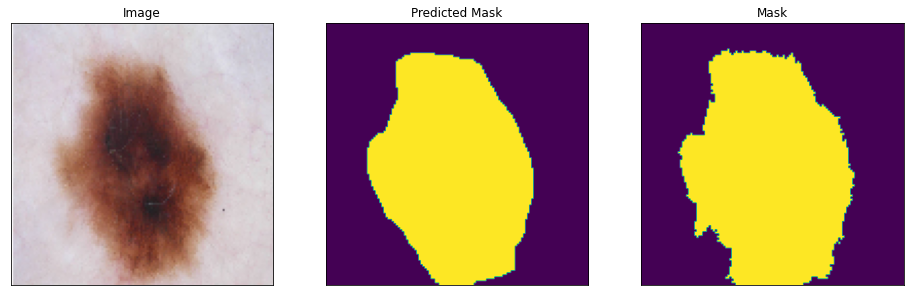

In [6]:
NotebookHelper().plot_images_masks(azure_model, test_images, test_masks)

### Calculate Metrics

This metric calculation is based on the [umetrics library](https://github.com/quantumjot/unet_segmentation_metrics).

The calculation uses the jaccard index threshold from the dataset description [landing page](https://challenge2018.isic-archive.com/task1/), section `metrics`, which is `0.65`.

In [7]:
from constants import TEST_DIR
from utils.helper import NotebookHelper

test_images, test_masks = NotebookHelper().load_images(TEST_DIR, load_masks=True, resize_to=(128, 128))

In [8]:
%%time

import numpy as np

predicted_masks_list = []

for test_image in test_images:
    test_image = np.expand_dims(test_image, axis=0)
    predicted_mask = azure_model.predict(test_image).round().squeeze(axis=0)
    predicted_masks_list.append(predicted_mask)
    
predicted_masks = np.stack(predicted_masks_list)

assert predicted_masks.shape == (len(test_masks), 128, 128, 1)

In [9]:
%%time

from utils.metrics import Metrics

metrics = Metrics().calculate_batch(
    masks=test_masks,
    predicted_masks=predicted_masks
)

metrics

CPU times: user 14.1 s, sys: 69.4 ms, total: 14.2 s
Wall time: 14.3 s


{'n_images': 300,
 'n_true_positives': 1021645,
 'n_true_positives_%': 0.8989452640711382,
 'n_true_negatives': 3687472,
 'n_true_negatives_%': 0.9758554976609723,
 'n_false_positives': 91235,
 'n_false_negatives': 114848,
 'iou_score': 0.8219148897497744,
 'threshold_jaccard_index': 0.7649807612619688,
 'jaccard_similarity_index': 0.8219148897497744,
 'dice': 0.8917741889592693,
 'f1_score': 0.44588709447963465,
 'sensitivity': 0.9103553094606324,
 'specificity': 0.9713861015548235,
 'accuracy': 0.9580723063151042}

#### Full Image Resolution Metrics

In [10]:
from constants import TEST_DIR
from utils.helper import NotebookHelper

test_images, test_masks = NotebookHelper().load_images(TEST_DIR, load_masks=True, resize_to=(1024, 768))

In [11]:
%%time

predicted_masks_list = []

for test_image in test_images:
    test_image = np.expand_dims(test_image, axis=0)
    predicted_mask = azure_model.predict(test_image).round().squeeze(axis=0)
    predicted_masks_list.append(predicted_mask)
    
predicted_masks = np.stack(predicted_masks_list)

assert len(predicted_masks.shape) == len(test_masks.shape)
assert predicted_masks.shape[-1] == 1

CPU times: user 1h 21min 3s, sys: 4min 29s, total: 1h 25min 33s
Wall time: 13min 35s


(768, 1024, 1)


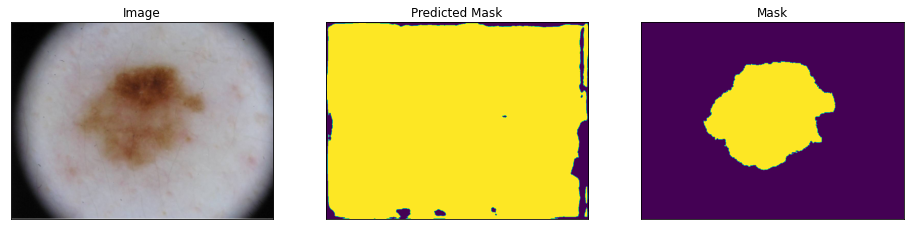

In [12]:
from utils.helper import Visualisation

index = 2

print(predicted_masks[index].shape)

Visualisation().plot_images(
    image=test_images[index],
    predicted_mask=predicted_masks[index],
    mask=test_masks[index]
)

In [13]:
%%time

from utils.metrics import Metrics

metrics = Metrics().calculate_batch(
    masks=test_masks,
    predicted_masks=predicted_masks
)

metrics

CPU times: user 11min 34s, sys: 6.14 s, total: 11min 41s
Wall time: 11min 53s


{'n_images': 300,
 'n_true_positives': 53636391,
 'n_true_positives_%': 0.9832975562366626,
 'n_true_negatives': 22995526,
 'n_true_negatives_%': 0.1267794441473461,
 'n_false_positives': 158386607,
 'n_false_negatives': 911076,
 'iou_score': 0.2530058550186568,
 'threshold_jaccard_index': 0.06585532061525612,
 'jaccard_similarity_index': 0.2530058550186568,
 'dice': 0.3550097970759345,
 'f1_score': 0.17750489853796725,
 'sensitivity': 0.9913238266539391,
 'specificity': 0.14899227458666037,
 'accuracy': 0.3248084047105577}

### Experiment 11 - VGG, ImageNet Weights, 192x256

Experiments based on [experiment list](https://docs.google.com/spreadsheets/d/1bsp8puoiK3ay0rUYdjFXcbxXf6iSJZenIWtoiWczlBA/edit#gid=1999600204https://docs.google.com/spreadsheets/d/1bsp8puoiK3ay0rUYdjFXcbxXf6iSJZenIWtoiWczlBA/edit#gid=1999600204).

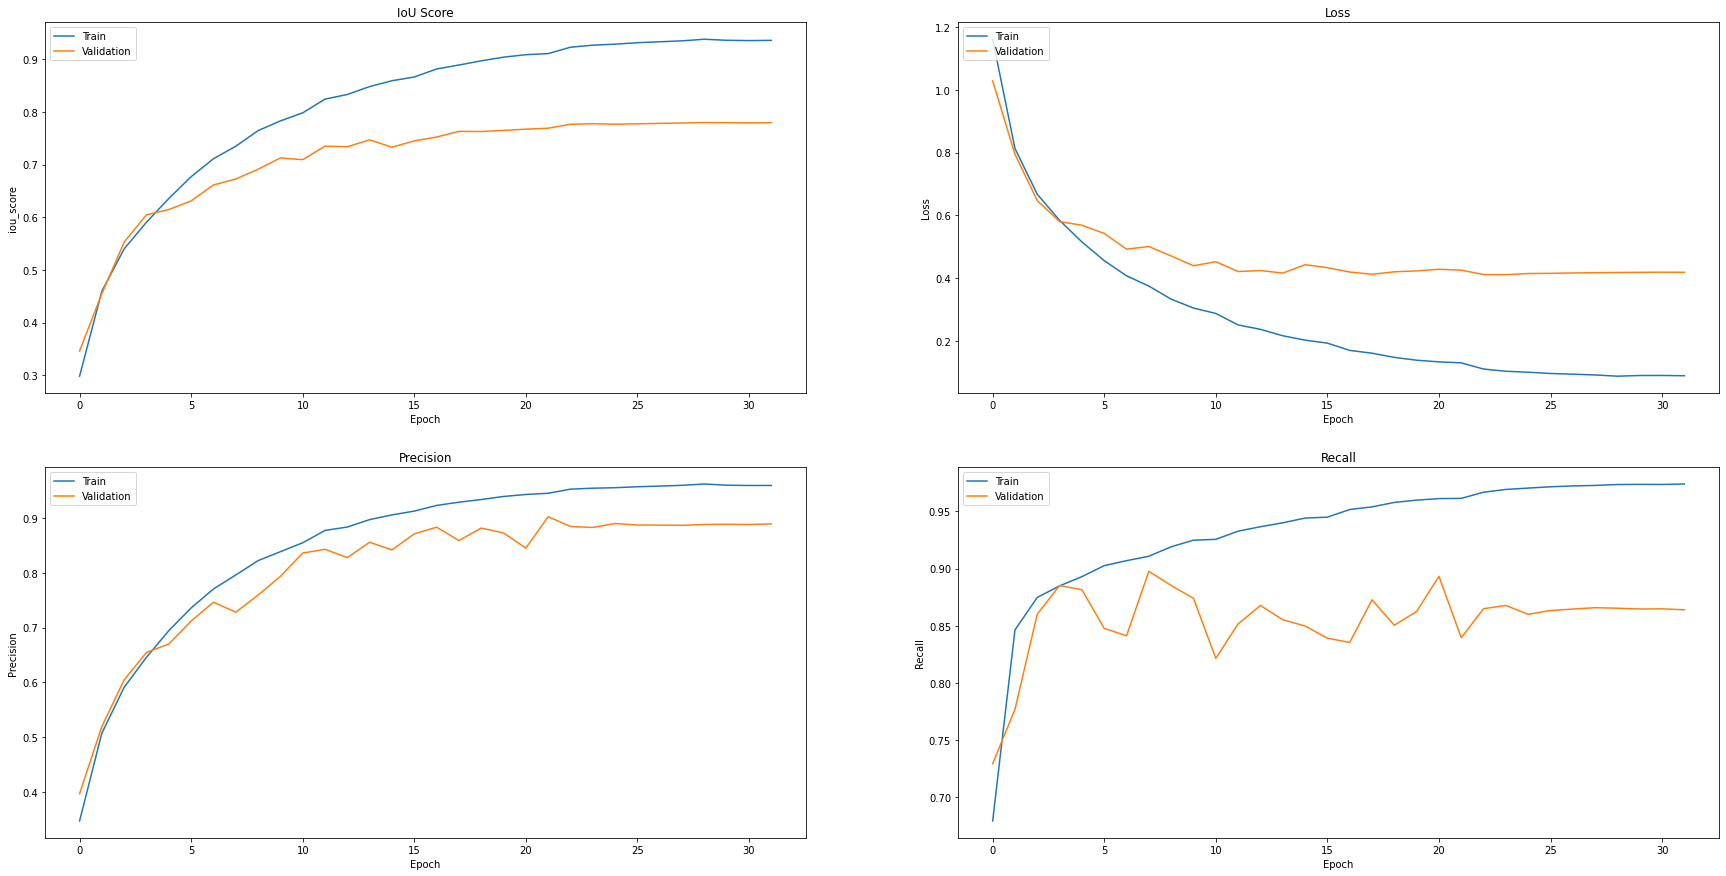

In [14]:
from utils.helper import Visualisation
import pickle
import os
from constants import EXPORT_DIR

AZURE_PATH = os.path.join(EXPORT_DIR, "azure", "2021_05_18_1529", "unet")

azure_hitory_path = os.path.join(AZURE_PATH, "unet_11_train_history.pkl")
azure_history = pickle.load(open(azure_hitory_path, "rb"))
Visualisation().plot_curves(azure_history)

#### Test Images (Unseen)

In [15]:
from baseline.trainer import Trainer
import segmentation_models as sm

azure_model = sm.Unet(encoder_weights='imagenet', activation='sigmoid')
azure_model.load_weights(os.path.join(AZURE_PATH, "unet_11_weights_only.h5"))
trainer = Trainer(model=azure_model)

In [16]:
from constants import TEST_DIR
from utils.helper import NotebookHelper

test_images, test_masks = NotebookHelper().load_images(TEST_DIR, load_masks=True, resize_to=(256, 192), size=5)

Image shape: (1, 192, 256, 3)
Predicted mask shape: (1, 192, 256, 1)
Mask shape: (192, 256, 1)


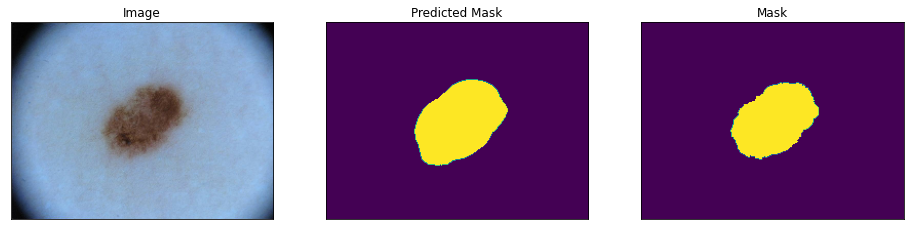

Image shape: (1, 192, 256, 3)
Predicted mask shape: (1, 192, 256, 1)
Mask shape: (192, 256, 1)


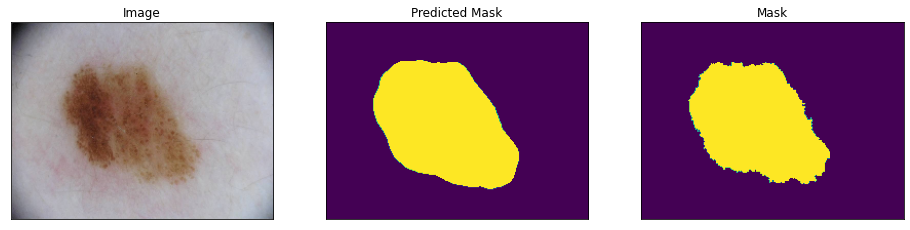

Image shape: (1, 192, 256, 3)
Predicted mask shape: (1, 192, 256, 1)
Mask shape: (192, 256, 1)


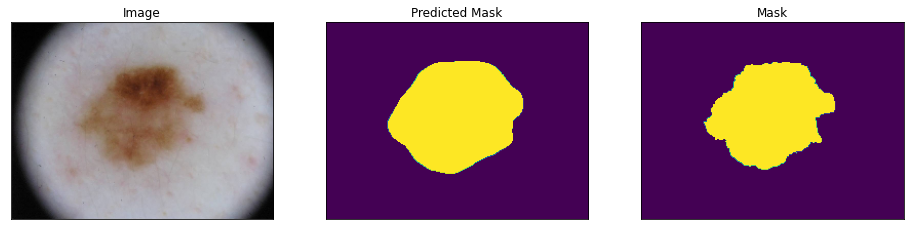

Image shape: (1, 192, 256, 3)
Predicted mask shape: (1, 192, 256, 1)
Mask shape: (192, 256, 1)


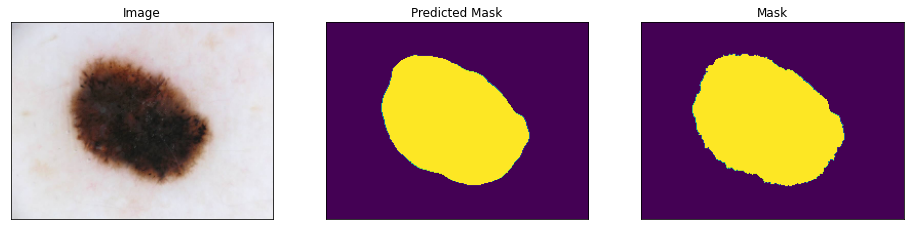

Image shape: (1, 192, 256, 3)
Predicted mask shape: (1, 192, 256, 1)
Mask shape: (192, 256, 1)


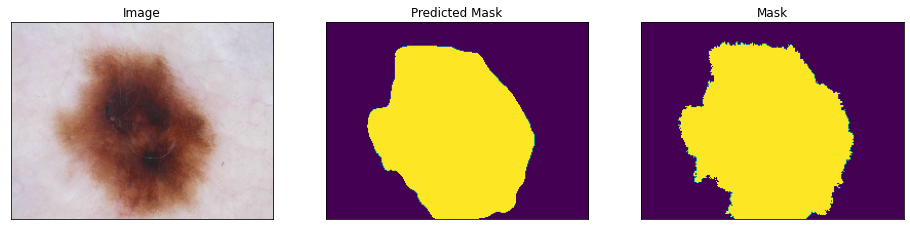

In [17]:
NotebookHelper().plot_images_masks(azure_model, test_images, test_masks)

### Calculate Metrics

This metric calculation is inspired on the [umetrics library](https://github.com/quantumjot/unet_segmentation_metrics).

The calculation uses the jaccard index threshold from the dataset description [landing page](https://challenge2018.isic-archive.com/task1/), section `metrics`, which is `0.65`.

In [18]:
from constants import TEST_DIR
from utils.helper import NotebookHelper

test_images, test_masks = NotebookHelper().load_images(TEST_DIR, load_masks=True, resize_to=(256, 192))

In [19]:
%%time

predicted_masks_list = []

for test_image in test_images:
    test_image = np.expand_dims(test_image, axis=0)
    predicted_mask = azure_model.predict(test_image).round().squeeze(axis=0)
    predicted_masks_list.append(predicted_mask)
    
predicted_masks = np.stack(predicted_masks_list)

assert predicted_masks.shape == (len(test_masks), 192, 256, 1)

In [20]:
%%time

from utils.metrics import Metrics

metrics = Metrics().calculate_batch(
    masks=test_masks,
    predicted_masks=predicted_masks
)

metrics

CPU times: user 42.3 s, sys: 186 ms, total: 42.5 s
Wall time: 42.7 s


{'n_images': 300,
 'n_true_positives': 3085416,
 'n_true_positives_%': 0.9049698584477739,
 'n_true_negatives': 11034827,
 'n_true_negatives_%': 0.973416105432982,
 'n_false_positives': 301360,
 'n_false_negatives': 323997,
 'iou_score': 0.8239736415349591,
 'threshold_jaccard_index': 0.7667946103697614,
 'jaccard_similarity_index': 0.8239736415349591,
 'dice': 0.8931774740193873,
 'f1_score': 0.44658873700969365,
 'sensitivity': 0.9215908567440476,
 'specificity': 0.9688335846086935,
 'accuracy': 0.9575902642144096}

#### Full Image Resolution Metrics

In [21]:
from constants import TEST_DIR
from utils.helper import NotebookHelper

test_images, test_masks = NotebookHelper().load_images(TEST_DIR, load_masks=True, resize_to=(1024, 768))

In [22]:
%%time

predicted_masks_list = []

for test_image in test_images:
    test_image = np.expand_dims(test_image, axis=0)
    predicted_mask = azure_model.predict(test_image).round().squeeze(axis=0)
    predicted_masks_list.append(predicted_mask)
    
predicted_masks = np.stack(predicted_masks_list)

assert len(predicted_masks.shape) == len(test_masks.shape)
assert predicted_masks.shape[-1] == 1

CPU times: user 1h 21min 12s, sys: 4min 34s, total: 1h 25min 46s
Wall time: 13min 47s


(768, 1024, 1)


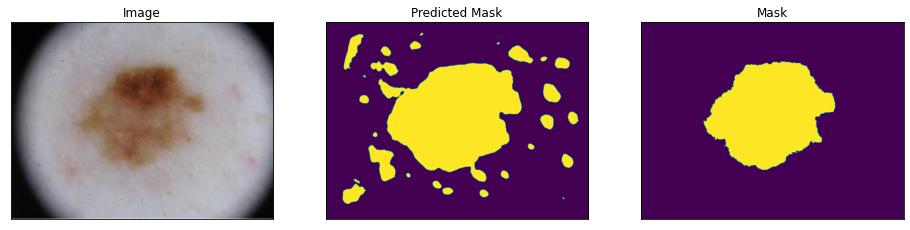

In [23]:
from utils.helper import Visualisation

index = 2

print(predicted_masks[index].shape)

Visualisation().plot_images(
    image=test_images[index],
    predicted_mask=predicted_masks[index],
    mask=test_masks[index]
)

In [24]:
%%time

from utils.metrics import Metrics

metrics = Metrics().calculate_batch(
    masks=test_masks,
    predicted_masks=predicted_masks
)

metrics

CPU times: user 11min 30s, sys: 5.56 s, total: 11min 36s
Wall time: 11min 45s


{'n_images': 300,
 'n_true_positives': 49651624,
 'n_true_positives_%': 0.9102461898001607,
 'n_true_negatives': 116958096,
 'n_true_negatives_%': 0.6448159698287372,
 'n_false_positives': 64424037,
 'n_false_negatives': 4895843,
 'iou_score': 0.4256762490890363,
 'threshold_jaccard_index': 0.22254898007432303,
 'jaccard_similarity_index': 0.4256762490890363,
 'dice': 0.5385104583704775,
 'f1_score': 0.26925522918523875,
 'sensitivity': 0.9289647115537899,
 'specificity': 0.6605304298247533,
 'accuracy': 0.7061840481228298}